In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from pyCascade import geomCreate as gC
from pyCascade import probeSetup, physics
from solid2 import *
import numpy as np
from matplotlib import pyplot as plt
import pandas
import os
from stl import mesh
from mpl_toolkits import mplot3d
from copy import deepcopy

# scratch_dir = pathlib.Path().absolute()
category =  "config2"
run = 33

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)

geom_write = False
probe_write = True

'/scratch/users/nbachand/Cascade/city_block_cfd'

In [2]:
x = 4
y = 3
z = 4
wthick = .1 #.001*np.min([x,y,z])
nx=3
ny=1
nz=2
roof_height = y
house_grid = [7, 5]
house_spacing = [4*x, 6*z]
interior_house = [(0,-2), (0,-1), (0,0), (0,1), (0,2)]
interior_house_skylights = [(-1,0)]
odd_offset = [-.5, 0]

if category == "config3":
    house_spacing  = [s * 1.5 for s in house_spacing]

house_dims = [nx*x, ny*y + roof_height, nz*z]
house_seperation = [house_spacing[0]-house_dims[0], house_spacing[1]-house_dims[2]]
block_slide = [house_spacing[i]/2 * odd_offset[i] for i in [0,1]]
block_size = [house_grid[0]*house_spacing[0], house_grid[1]*house_spacing[1]]
# block_size = [block_size[d] + (house_seperation[1 - d] - house_seperation[d]) / 2 for d in [0,1]]
domain_l = 2 * np.max([block_size[0], block_size[1]])
domain_l += 2 * block_slide[0]
domain_size = [domain_l, domain_l]
domain_height = max(domain_size) / 3
# domain_height = (max(domain_size) + ny*y + roof_height) / np.pi
domain_size.insert(1, domain_height)

print(domain_size)


[232.0, 77.33333333333333, 232.0]


Vertical Profiles

In [3]:
[Lx, Ly, Lz] = domain_size
n_stack_floor = int(Ly+1)
n_stack_roof = int(Ly-(house_dims[1]))

# probe_cols = { 
#     (6,0): (house_dims[0]/2, -house_seperation[1]/2, [0, Ly], n_stack_floor), # between z
#     (0,4): (-house_seperation[0]/2, house_dims[2]/2, [0, Ly], n_stack_floor), # between x
#     (6,4): (-house_seperation[0]/2, -house_seperation[1]/2, [0, Ly], n_stack_floor), # between x z
#     (0,0): (house_dims[0]/2, house_dims[2]/2, [house_dims[1], Ly], n_stack_roof) # roof
# }
i = 0
probe_cols = {}
for h in interior_house:
    i += 1
    if i > 3: break
    probe_cols[h] = (-house_seperation[0]/2, -house_seperation[1]/2, [0, Ly], n_stack_floor) # between x z

probe_cols

{(0, -2): (-2.0, -8.0, [0, 77.33333333333333], 78),
 (0, -1): (-2.0, -8.0, [0, 77.33333333333333], 78),
 (0, 0): (-2.0, -8.0, [0, 77.33333333333333], 78)}

In [4]:
rooms, rooms_params = gC.makeRooms(x,y,z,wthick,nx,ny,nz)
rooms_params = gC.identify_openings(rooms_params)
rooms_params['door_locations'] = [[1,1,'x']]
rooms_params['window_locations'].remove([2,0,'x'])
rooms_params['window_locations'].remove([2,1,'x'])
rooms_params['wall_locations'] = [[2,1,'z']]

In [5]:
domain = gC.ProbedGeom(cube(domain_size, center = True))
domain.translate([0, domain_size[1]/2, 0])

nxrange = np.arange(house_grid[0]) - (house_grid[0] + odd_offset[0] - 1) / 2
nzrange = np.arange(house_grid[1]) - (house_grid[1] + odd_offset[1] - 1) / 2

display(nxrange)
display(nzrange)

array([-2.75, -1.75, -0.75,  0.25,  1.25,  2.25,  3.25])

array([-2., -1.,  0.,  1.,  2.])

In [13]:
house_list = []
house_coordinates = {}

for i in nxrange:
    exterior = gC.ProbedGeom(cube([nx*x, ny*y, nz*z]))
    roof = gC.makeRoof(x*nx, x*nx*2/3, z*nz, 0, roof_height, y*ny)
    doors = gC.makeDoors(rooms_params, y*.25, y*.75, 10, 10)
    windows = gC.makeWindows(rooms_params, y*.25, y*.25, 10, 10, extraProbeOffset = y*.5)
    walls = gC.openWalls(rooms_params, z-2*wthick, y-2*wthick, 0, 0)
    # skylights = gC.makeSkylights(rooms_params, y*.25, y*.25, y, 10, 10)
    skylights = gC.makeSkylights(rooms_params, y*.25, y*.25, y*1.25, 10, 10)
    for k in nzrange:
        house_coord = (round(i),round(k))
        if house_coord in interior_house:
            house = deepcopy(exterior+roof-rooms-doors-windows-walls)
            house.append_names(f"h_{house_coord[0]}-{house_coord[1]}")
        # elif house_coord in interior_house_skylights:
        #     house = deepcopy(exterior+roof-rooms-doors-windows-walls-skylights)
        #     house.append_names("sl")
        else:
            house = exterior+roof
        if house_coord in probe_cols:
            col_name = f"col_{house_coord[0]}-{house_coord[1]}"
            col_name = col_name.replace("--", "-n")
            col_probe = probeSetup.Probes(name = col_name)
            col_probe.y_col(*probe_cols[house_coord])
            house.probes += [col_probe]
        del_x = Lx / 4 - nx * x / 2 + (i + odd_offset[0] * (k % 2)) * house_spacing[0]
        del_z = Lz / 4 - nz * z / 2 + (k + odd_offset[1] * (i % 2)) * house_spacing[1]
        del_x += block_slide[0]/2 #averageing zone intersections
        del_z += -block_slide[0]/2 #averageing zone intersections
        house_coordinate =  [del_x, 0, del_z]
        house.translate(house_coordinate)
        house_coordinates[(i,k)] =  house_coordinate
        house.checkIntegrity()
        house_list.append(deepcopy(house))
for house in house_list:
    house.checkIntegrity()
houses = gC.sumProbedGeom(house_list)

[houses_x, houses_z, houses_xz] = [deepcopy(houses) for i in range(3)]
houses_x.rotate([0,-90,0])
houses_x.append_names("Bx")
houses_z.rotate([0,90,0])
houses_z.append_names("Bz")
houses_xz.rotate([0, 180, 0])
houses_xz.append_names("Bxz")

houses = gC.sumProbedGeom([houses, houses_x, houses_z, houses_xz])

neighborhood = domain - houses
neighborhood.removeZeroProbes()

geom_path = f"{home_dir}/city_block_geom/OpenSCAD/{category}"
if geom_write: scad_render_to_file(neighborhood.geom, f"{geom_path}/mesh_geom.scad")
print(len(neighborhood.probes))

if geom_write: scad_render_to_file(houses.geom, f"{geom_path}/houses.scad")
open_space = gC.ProbedGeom(cube((domain_size[0], 2*ny*y, domain_size[2]), center=True))
open_space.translate((0, 1.9*y, 0))
open_houses = houses - open_space
if geom_write: scad_render_to_file(open_houses.geom, f"{geom_path}/open_houses.scad")


352


## Generated Turbulence

In [7]:
housesGen = [deepcopy(houses) for i in range(4)]
housesGen[1].translate([Lx, 0, 0])
housesGen[2].translate([0, 0, Lz])
housesGen[3].translate([Lx, 0, Lz])

housesGen = gC.sumProbedGeom(housesGen)
housesGen.translate([-Lx/2, 0, -Lz/2])
housesGen.rotate([0, 45, 0])

if geom_write: scad_render_to_file(housesGen.geom, f"{geom_path}/housesGen.scad")

domain_size_gen = [Lx*8, Ly, Lz*6]
display(domain_size_gen)

domainGen = gC.ProbedGeom(cube(domain_size_gen, center = True))
domainGen.translate([0, domain_size_gen[1]/2, 0])
mesh_geom_gen = domainGen - housesGen
if geom_write: scad_render_to_file(mesh_geom_gen.geom, f"{geom_path}/mesh_geom_gen.scad")

[1856.0, 77.33333333333333, 1392.0]

## Window Probes

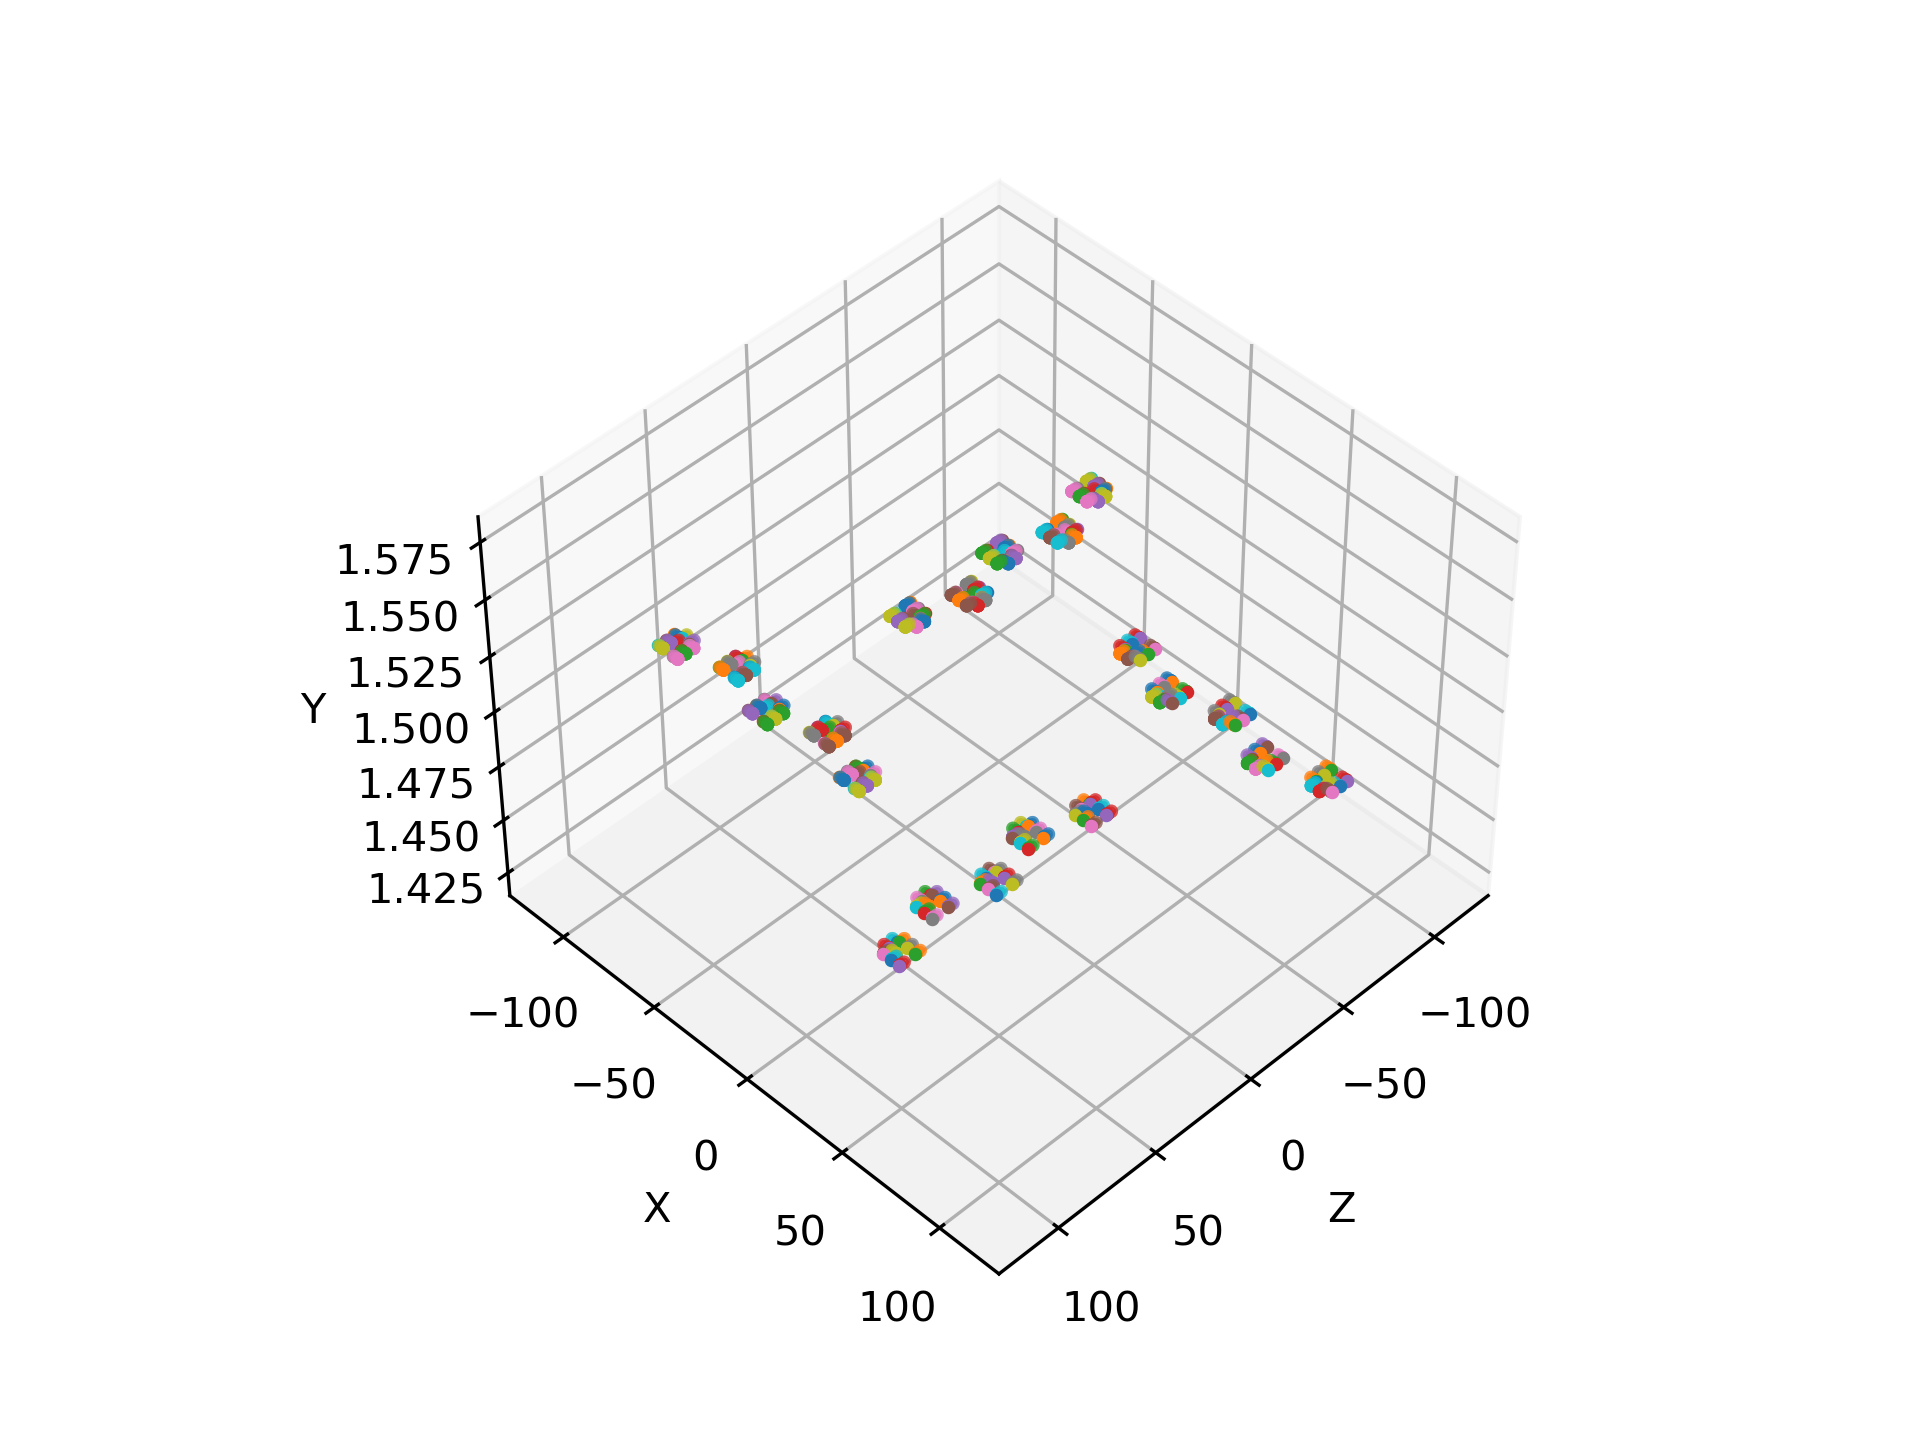

Appending to file /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R33/probes/locations/extraProbe.txt
Appending to file /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R33/probes/locations/extraProbe.txt
Appending to file /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R33/probes/locations/extraProbe.txt
Appending to file /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R33/probes/locations/extraProbe.txt
Appending to file /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R33/probes/locations/extraProbe.txt
Appending to file /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R33/probes/locations/extraProbe.txt
Appending to file /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R33/probes/locations/extraProbe.txt
Appending to file /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R33/probes/locations/extraProbe.txt
Appending to file /scratch/users/nbachand/Cascade/city_block_cfd

In [14]:
figure = plt.figure(dpi = 300)
ax = figure.add_subplot(projection='3d')


# # Load the STL files and add the vectors to the plot
# geom_stl = mesh.Mesh.from_file(f"{geom_path}/open_houses.stl")

# plot_vectors = geom_stl.vectors
# ax.add_collection3d(mplot3d.art3d.Poly3DCollection(plot_vectors))

# # Auto scale to the mesh size
# scale = geom_stl.points.flatten()
# ax.auto_scale_xyz(scale, scale, scale)
# ax.set_ylim(0, Ly)

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

for p in neighborhood.probes:
    if "col" not in p.name:# and 'extraProbe' not in p.name:
        ax.scatter(p.tile[:,0], p.tile[:,1], p.tile[:,2], marker='.')
        # ax.scatter(np.mean(p.tile[:,0]), np.mean(p.tile[:,1]), np.mean(p.tile[:,2]), marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=45, azim=45, roll=0, vertical_axis='y')
# plt.axis('square')

plt.show()

if probe_write: neighborhood.writeProbesToSingleFile(
    f"{scratch_dir}/CHARLES/{category}/R{run}/probes/locations/",
    nameInclude="extraProbe")

In [ ]:
figure = plt.figure(dpi = 180)
ax = figure.add_subplot(projection='3d')


# Load the STL files and add the vectors to the plot
geom_stl = mesh.Mesh.from_file(f"{geom_path}/houses.stl")

plot_vectors = geom_stl.vectors
ax.add_collection3d(mplot3d.art3d.Poly3DCollection(plot_vectors))

# Auto scale to the mesh size
scale = geom_stl.points.flatten()
ax.auto_scale_xyz(scale, scale, scale)
ax.set_ylim(0, Ly)

for p in neighborhood.probes:
    if "col" in p.name:
        ax.scatter(p.tile[:,0], p.tile[:,1], p.tile[:,2], marker="o", lw = 2,  s=(172./figure.dpi)**2, label = p.name)

# Show the plot to the screen
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')                                                                                                  
ax.view_init(elev=60, azim=30, roll=0, vertical_axis='y')
# plt.legend()
plt.show()

if probe_write: neighborhood.writeProbesToFiles(
    f"{scratch_dir}/CHARLES/{category}/R{run}/probes/locations/",
    nameInclude="col")

# figure.savefig(f"{geom_path}/houses")

In [ ]:
# [house_coordinates[h] for h in interior_house]

In [ ]:
vK_const = .41
hm = 6
rho = 1.225
mu = 1.7894e-5
# Re_tau = 43300
z_ref = 10 # really y_ref
U_ref = 4

z_0 = 0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = vK_const*U_ref/np.log(z_ref/z_0)
display(f"uStar is {shear_vel}")

plt.figure()
LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'Dt': .01,
    'z_values' : np.linspace(0,Ly,10000)
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

# checking against charles code
# approximate log law mean profile
y_scaled = (LES_params['z_values']-disp)/z_0
y_scaled = np.maximum(1.0, y_scaled)
ux = (shear_vel/vK_const)*np.log(y_scaled)

# physics_setup.plot_log_wind()

plt.plot(ux, LES_params['z_values'])
plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

In [ ]:
physics_setup.plot_spinup_velocity()

# physics_setup.LES_params['spinup_profile']

# plt.plot(ux, LES_params['z_values'])

# plt.plot(2*ux - np.flip(spinup_profile), LES_params['z_values'])

physics_setup.plot_spinup_velocity2()

plt.legend(('Expected ABL', 'Triangular Profile', "Nick's Spinnup"))

# plt.plot(ux+2.5*physics_setup.LES_params['uStar'], LES_params['z_values'])

plt.show()


In [ ]:
# For momentum source
y_ref = 0.9 *  Ly
u_t = np.mean(physics_setup.LES_params['log_wind'][physics_setup.LES_params['z_values'] >= y_ref])
display(f"u_t for y_ref = {y_ref} is {u_t}")



In [ ]:
wall_spacing = y * (ny + 1) / 10 #physics_setup.LES_params['flatplate']['spacingW']*10
growth_rate = 1.1
a = (growth_rate-1)/growth_rate
level_heights = []
n_levels = -1
total_height = 0

while total_height < Ly:
    level_height = wall_spacing*(2 ** (n_levels))/a
    level_heights.append(level_height)
    total_height += level_height
    n_levels += 1

display(f"Number of refinement levels is {n_levels}") # not counting level 0

hcp_delta = wall_spacing*2**(n_levels)

for level in range(n_levels, 0, -1):
    height = level_heights[n_levels - level]
    if level == n_levels:
        del_height = height
    else:
        del_height = level_heights[n_levels - level + 1] - height
    display(f'Level {level} has height {total_height:f} and spans {height:f}')
    level_hcp_delta = hcp_delta/2**(level)
    display(f'NLAYERS is {del_height/level_hcp_delta}')

display(f'hcp delta is {hcp_delta:f} for wall spacing {wall_spacing:f} and domain height {Ly:f}')

In [ ]:
hcp_delta = 19.333
interior_level = n_levels + 3
vol_scale_factor = 1.1
del_interior = hcp_delta / (2 ** interior_level) * vol_scale_factor


# For inclusion in charles.in
print("# For momentum source")
print(f"VOLUMETRIC_PROBE NAME=probes/VolProbe90X \
  INTERVAL=$(flush_probes) GEOM BOX {-Lx/2:f} {Lx/2:f} {y_ref:f} {Ly:f} {-Lz/2:f} {Lz/2:f} \
  VARS=comp(u,0)")
print(f"VOLUMETRIC_PROBE NAME=probes/VolProbe90Z \
  INTERVAL=$(flush_probes) GEOM BOX {-Lx/2:f} {Lx/2:f} {y_ref:f} {Ly:f} {-Lz/2:f} {Lz/2:f} \
  VARS=comp(u,2)")

neighborhood.removeZeroProbes()
print("\n# For other volumetric probes")
for p in neighborhood.probes:
  if p.type == "VOLUMETRIC_PROBE":
    p.getProbeCall(del_interior, "comp(u,0) comp(u,1) comp(u,2) p")
    print(p.probeCall)

print("\n# For flux probes")
for p in neighborhood.probes:
  if p.type == "FLUX_PROBE":
    p.getProbeCall(del_interior, "")
    print(p.probeCall)

print("\n# For output Probe files")
for p in neighborhood.probes:
  if p.type == "PROBE":
    p.getProbeCall(del_interior, "comp(u,0) comp(u,1) comp(u,2) p")
    print(p.probeCall)


In [ ]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )

In [ ]:
# hcp_delta = 9.6
# n_std = 1
# U_ref = physics_setup.LES_params['log_wind']
# U_ref += n_std*(2.5*physics_setup.LES_params['uStar'])
# z_levels = []
# n = 5
# for level in range(n):
#     U_level = U_ref[-1]/(2**level)
#     ind_level = np.argmin(np.abs(U_ref-U_level))
#     z_level = physics_setup.LES_params['z_values'][ind_level]
#     z_levels.append(z_level)

#     display(f'level {level} is at {z_level} with velocity of velocity {U_level}')

# z_levels.append(0)
# for level in range(n):
#     h_level = z_levels[level] - z_levels[level+1]
#     cell_size = hcp_delta/(2**level)
#     h_level = np.max((h_level, 5*cell_size))
#     h_level = np.round(h_level, 0)
#     display(f'level {level} has height of {h_level}')

# display(f'ground mesh size is {cell_size}')

In [ ]:
P0 = 0.6
r = 1.1
y = np.linspace(0, 100, 1000)
s = np.zeros_like(y)
h = np.zeros_like(y)
s[0] = P0
h[0] = P0

h_an = np.zeros_like(y)

for i in range(1, len(y)):
    s[i] = s[i-1]*r
    h[i] = h[i-1] + s[i]
    if h[i] > y[-1]:
        break
plt.figure()
plt.scatter(s,h)
plt.plot(P0+(r-1)/r*y, y)

In [ ]:
# write a function that reads text, looks for three consecutive numbers, and multiplies them by scaling factors
def scale_text(text, scale_factors):
    text = text.split(' ')
    for i in range(len(text)-2):
        try:
            for j in [i, i+1, i+2]:
                float(text[j])
            for j in [i, i+1, i+2]:
                text[j] = float(text[j])
                text[j] *= scale_factors[j-i]
                text[j] =   f'{round(text[j], 1):.1f}'
                text[j] = text[j].replace('.0', '')
        except:
            pass
    text = ' '.join(map(str, text))
    return text

# read text from file and preserve line breaks
with open(f"{scratch_dir}/CHARLES/{category}/R{run}/charles.in", 'r', newline = '') as f:
    text = f.read()
text = scale_text(text, [4/3,1,4/3])
print(text)
